In [1]:
import numpy as np
import sys
import time
import h5py
from tqdm import tqdm

import numpy as np
import re
from math import ceil
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#import pickle5 as pickle

from sklearn.model_selection import train_test_split

from scipy.sparse import load_npz
from glob import glob

#from transformers import get_constant_schedule_with_warmup
from sklearn.metrics import precision_score,recall_score,accuracy_score

#from src.train import trainModel
from src.dataloader import getData,spliceDataset,h5pyDataset,getDataPointList,getDataPointListFull,DataPoint
#from src.weight_init import keras_init
#rom src.losses import categorical_crossentropy_2d
#rom src.models import SpliceAI_10K
#from src.evaluation_metrics import print_topl_statistics
import copy
#import tensorflow as tf

In [2]:
#!pip install pickle5

In [3]:
!nvidia-smi

Mon Mar 27 17:14:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   33C    P0    32W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

In [4]:
rng = np.random.default_rng(23673)

In [5]:
data_dir = '../Data'

In [6]:
#setType = 'all'
#annotation, transcriptToLabel, seqData = getData(data_dir, setType)

In [7]:
#gtf = None

In [8]:
L = 32
N_GPUS = 8
k = 2
# Hyper-parameters:
# L: Number of convolution kernels
# W: Convolution window size in each residual unit
# AR: Atrous rate in each residual unit

W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])
BATCH_SIZE = k*6*N_GPUS


CL = 2 * np.sum(AR*(W-1))

In [9]:
SL=5000
CL_max=10000

In [10]:
lead_sQTL = pd.read_csv('/odinn/data/dataprocessing/rnasplice-blood/curry/sQTL_summary/lead_sQTL.gor', sep='\t')

In [11]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/gene_boundries.pkl', 'rb') as f:
    gene_boundries = pickle.load(f)
    
def unionBoundry(names,gene_boundries):
    for i,name in enumerate(names):
        if i==0:
            gene_start,gene_end = gene_boundries[name]
        else:
            start,end = gene_boundries[name]
            gene_start,gene_end = np.min([gene_start,start]),np.max([gene_end,end])
    return gene_start,gene_end
inside_gene = []

for i in tqdm(range(lead_sQTL.shape[0])):
    gene,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = lead_sQTL.iloc[i,:][['Gene_name','Chrom','Strand','Pos','Startx','End','REF','ALT','splice_event_id']]
    names = gene.split(',')
    gene_start,gene_end = unionBoundry(names,gene_boundries)
    inside_gene.append(gene_start <= pos <= gene_end)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 257372/257372 [01:50<00:00, 2327.11it/s]


In [12]:
#lead_sQTL = lead_sQTL[lead_sQTL['Max_Consequence']!='intergenic_variant']
#lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_downstream']
#lead_sQTL = lead_sQTL[lead_sQTL['Pos_bin']!='distant_upstream']
lead_sQTL = lead_sQTL[inside_gene]
print(np.sum(lead_sQTL['REF']==lead_sQTL['ALT']))
lead_sQTL = lead_sQTL[lead_sQTL['REF']!=lead_sQTL['ALT']]
print(f'{0.05}/{lead_sQTL.shape[0]}')
lead_sQTL = lead_sQTL[lead_sQTL['Pval']<=0.05/lead_sQTL.shape[0]]

16091
0.05/146407


In [ ]:
sQTL_not_sQTL_pairs = pd.read_csv('../Data/Not_sQTLs_pairs_adiposeLDsQTLfiltered.tsv',sep='\t')
not_sQTL_info = pd.read_csv('../Data/not_sQTL_w_info.gor',sep='\t')

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict
sQTL_to_not_sQTL = defaultdict(list)
for i in tqdm(range(sQTL_not_sQTL_pairs.shape[0])):
    sQTL_to_not_sQTL[sQTL_not_sQTL_pairs.iloc[i,0]].append(sQTL_not_sQTL_pairs.iloc[i,1])

not_sQTL_to_MAF = defaultdict(lambda: float('-inf'))
not_sQTL_to_pos = defaultdict(lambda: 0)
for i in tqdm(range(not_sQTL_info.shape[0])):
    not_sQTL_to_MAF[not_sQTL_info.iloc[i,:]['marker']] = not_sQTL_info.iloc[i,:]['Freq']
    not_sQTL_to_pos[not_sQTL_info.iloc[i,:]['marker']] = not_sQTL_info.iloc[i,:]['Pos']

In [19]:


def get_not_sqtl(variant,variant_maf,variant_gene,sQTL_to_not_sQTL,not_sQTL_to_MAF,not_sQTL_to_pos):
    not_sQTLs = np.array(sQTL_to_not_sQTL[variant])
    if len(not_sQTLs)==0:
        #print('No match')
        return None
    else:
        inside_gene = []
        names = variant_gene.split(',')
        gene_start,gene_end = unionBoundry(names,gene_boundries)
        for not_sQTL in not_sQTLs:
            inside_gene.append(gene_start <= not_sQTL_to_pos[not_sQTL] <= gene_end)
        if np.sum(inside_gene)==0:
            return None
        else:
            not_sQTLs = not_sQTLs[inside_gene]
            mafs = np.array([not_sQTL_to_MAF[x] for x in not_sQTLs])
            #print(np.absolute(tmp2['Freq'].values-variant['ImpMAF']))
            diff = np.absolute(mafs-variant_maf)
            return not_sQTLs[np.argmin(diff)]

def get_variant_pairs(variant,variant_maf,variant_gene,sQTL_to_not_sQTL,not_sQTL_to_MAF,not_sQTL_to_pos):
    return (variant,get_not_sqtl(variant,variant_maf,variant_gene,sQTL_to_not_sQTL,not_sQTL_to_MAF,not_sQTL_to_pos),variant_gene)

variant_pairs = {}
variants = lead_sQTL
for i in tqdm(range(variants.shape[0])):
    sqtl,no_sqtl,variant_gene = get_variant_pairs(variants.iloc[i,2],variants.iloc[i,10],variants.iloc[i,:]['Gene_name'],sQTL_to_not_sQTL,not_sQTL_to_MAF,not_sQTL_to_pos)
    variant_pairs[f'{sqtl}__{variant_gene}'] = no_sqtl
    
results = []
for i in tqdm(range(lead_sQTL.shape[0])):
    gene_name,chrom,strand,start,end,marker,splice_id = lead_sQTL.iloc[i][['Gene_name','Chrom','Strand','Startx','End','Name','splice_event_id']]
    no_sqtl = variant_pairs[f'{marker}__{gene_name}']
    try:
        if no_sqtl!=None:
            #pos = int(no_sqtl.split(':')[1])
            tmp = not_sQTL_info[not_sQTL_info['marker']==no_sqtl][['Pos','Ref','Alt']]
            results.append([gene_name,chrom,tmp['Pos'].values[0],strand,start,end,no_sqtl,splice_id,tmp['Ref'].values[0],tmp['Alt'].values[0]])
    except:
        print(no_sqtl,'failed')
    
no_sQTLs = pd.DataFrame(results)
no_sQTLs.columns = ['Gene_name','Chrom','Pos','Strand','Startx','End','Name','splice_event_id','Ref','Alt']
no_sQTLs.to_csv('../Data/no_sQTLs_3.csv',index=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 80999/80999 [31:24<00:00, 42.98it/s]


In [20]:
import pyfastx
data_dir = '../Data/'
fasta_file_path = '../Data/genome.fa'
gtf_file_path = '../Data/Homo_sapiens.GRCh38.87.gtf'
fasta = pyfastx.Fasta(fasta_file_path)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D, Cropping1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import add
import tensorflow.keras.backend as kb
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Lambda

def ResidualUnit(l, w, ar):
    # Residual unit proposed in "Identity mappings in Deep Residual Networks"
    # by He et al.

    def f(input_node):

        bn1 = BatchNormalization()(input_node)
        act1 = Activation('relu')(bn1)
        conv1 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act1)
        bn2 = BatchNormalization()(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv1D(l, [w], dilation_rate=[ar], padding='same')(act2)
        output_node = add([conv2, input_node])

        return output_node

    return f


def SpliceAI(L, W, AR):
    # L: Number of convolution kernels
    # W: Convolution window size in each residual unit
    # AR: Atrous rate in each residual unit

    assert len(W) == len(AR)

    CL = 2 * np.sum(AR*(W-1))

    input0 = Input(shape=(None, 4))
    conv = Conv1D(L, 1)(input0)
    skip = Conv1D(L, 1)(conv)

    for i in range(len(W)):
        conv = ResidualUnit(L, W[i], AR[i])(conv)
        
        if (((i+1) % 4 == 0) or ((i+1) == len(W))):
            # Skip connections to the output after every 4 residual units
            dense = Conv1D(L, 1)(conv)
            skip = add([skip, dense])

    skip = Cropping1D(int(CL/2))(skip)

    output0 = [[] for t in range(1)]

    for t in range(1):
        output0[t] = Conv1D(3, 1, activation='softmax')(skip)
    
    model = Model(inputs=input0, outputs=output0)

    return model


def categorical_crossentropy_2d(y_true, y_pred):
    # Standard categorical cross entropy for sequence outputs
    weights = [3.33445928e-01, 1.97431150e+03, 1.97432843e+03]
    return - kb.mean(weights[0]*y_true[:, :, 0]*kb.log(y_pred[:, :, 0]+1e-10)
                   + weights[1]*y_true[:, :, 1]*kb.log(y_pred[:, :, 1]+1e-10)
                   + weights[2]*y_true[:, :, 2]*kb.log(y_pred[:, :, 2]+1e-10))


2023-02-14 12:18:45.239318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [22]:
from pkg_resources import resource_filename
from tensorflow.keras.models import load_model 

models = []
n_models = 5

paths = ('models/spliceai{}.h5'.format(x) for x in range(1, 6))
models = [load_model(resource_filename('spliceai', x)) for x in paths]

device = torch.device("cpu")

2023-02-14 12:18:49.259727: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-14 12:18:51.005522: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:5e:00.0
2023-02-14 12:18:51.006392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 1 with properties: 
name: NVIDIA Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:86:00.0
2023-02-14 12:18:51.006437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-02-14 12:18:51.011474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-02-14 12:18:51.013940: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library l

In [20]:
#gene_boundries = {}
#for gene in tqdm(genes):
#    gene_boundries[gene["gene_name"][0]] = [int(gene[3]),int(gene[4])]

In [21]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/gene_boundries.pkl', 'wb') as f:
#    pickle.dump(gene_boundries, f)

In [26]:
no_sQTLs = pd.read_csv('../Data/no_sQTLs.csv')

In [20]:
#def reverse_comp(seq):
#    seq = seq.replace("A", "t").replace(
#                "C", "g").replace("T", "a").replace("G", "c")
#    seq = seq.upper()

    # reverse strand
#    seq = seq[::-1]
#    return seq

In [27]:
no_sQTLs

,Gene_name,Chrom,Pos,Strand,Startx,End,Name,splice_event_id,Ref,Alt
0,"RP11-206L10.2,RP5-857K21.4",chr1,769257,-,766364,768547,chr1:769257:SG,chr1:766364:768547:2,G,A
1,"RP11-206L10.2,RP5-857K21.4",chr1,769257,-,766407,768547,chr1:769257:SG,chr1:766407:768547:2,G,A
2,RP11-206L10.8,chr1,806999,-,805891,808574,chr1:806999:SG,chr1:805891:808574:5,A,G
3,NOC2L,chr1,942146,-,946610,948130,chr1:942146:SG,chr1:946610:948130:9,C,T
4,NOC2L,chr1,942601,-,946545,946756,chr1:942601:SG,chr1:946545:946756:9,G,C
...,...,...,...,...,...,...,...,...,...,...
41607,EHMT1,chr9,137752963,+,137728529,137743391,chr9:137752963:SG,chr9:137728529:137743391:2122,C,T
41608,EHMT1,chr9,137752963,+,137728529,137743394,chr9:137752963:SG,chr9:137728529:137743394:2122,C,T
41609,EHMT1,chr9,137816043,+,137816062,137817394,chr9:137816043:SG,chr9:137816062:137817394:2129,G,A
41610,EHMT1,chr9,137816043,+,137816062,137817438,chr9:137816043:SG,chr9:137816062:137817438:2129,G,A


In [24]:
def predictSplicing(seq,models):
    outputs = []
    for i in range(seq.shape[0]):
        Xc = torch.tensor(seq[i,:,:], device=device).float().unsqueeze(0).numpy()
        #Xc = torch.swapaxes(batch_features,1,2)
        predictions = []
        for v in range(n_models):
            Yp = models[v].predict(Xc, batch_size=1)
            predictions.append(Yp)
        predictions = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4])/n_models
        outputs.append(np.swapaxes(predictions,1,2))
    
    outputs = np.concatenate(outputs,axis=2)
    #outputs = outputs.cpu().detach().numpy()
    return outputs

def plotPrediction(outputs):
    plt.rcParams.update({'font.size': 18})
    fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(22, 6),sharex=True)
    x = np.arange(outputs.shape[2])
    ax1.plot(x,outputs[0,1,:],linewidth=2,zorder=-32)
    ax2.plot(x,outputs[0,2,:],linewidth=2,zorder=-32)
    plt.xlabel('Distance from transcript start (nt)')
    ax1.set_ylabel('Acceptor score')
    ax2.set_ylabel('Donor Score')
    ax1.legend(prop={'size': 14})
    ax2.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

def ceil_div(x, y):

    return int(ceil(float(x)/y))


IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

def one_hot_encode(Xd):

    return IN_MAP[Xd.astype('int8')]

def reformat_data(X0):
    # This function converts X0, Y0 of the create_datapoints function into
    # blocks such that the data is broken down into data points where the
    # input is a sequence of length SL+CL_max corresponding to SL nucleotides
    # of interest and CL_max context nucleotides, the output is a sequence of
    # length SL corresponding to the splicing information of the nucleotides
    # of interest. The CL_max context nucleotides are such that they are
    # CL_max/2 on either side of the SL nucleotides of interest.

    num_points = ceil_div(len(X0)-CL_max, SL)
    Xd = np.zeros((num_points, SL+CL_max))
    X0 = np.pad(X0, [0, SL], 'constant', constant_values=0)

    for i in range(num_points):
        Xd[i] = X0[SL*i:CL_max+SL*(i+1)]

    return Xd

def seqToArray(seq,strand):
    seq = 'N'*(CL_max//2) + seq + 'N'*(CL_max//2)
    seq = seq.upper()
    seq = re.sub(r'[^AGTC]', '0',seq)
    seq = seq.replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        X0 = np.asarray([int(x) for x in seq])
            
    elif strand == '-':
        X0 = (5-np.asarray([int(x) for x in seq[::-1]])) % 5  # Reverse complement
        
    Xd = reformat_data(X0)
    return  one_hot_encode(Xd)
    
#acceptorDeltas = []
#donorDeltas = []
results = {}
#markers = lead_sQTL['Name'].drop_duplicates().values



for i in tqdm(range(no_sQTLs.shape[0])):
    gene,marker,chrm,strand,pos,jn_start,jn_end,ref_s,alt_s,event_id = no_sQTLs.iloc[i,:][['Gene_name','Name','Chrom','Strand','Pos','Startx','End','Ref','Alt','splice_event_id']]
    names = gene.split(',')
    gene_start,gene_end = unionBoundry(names,gene_boundries)
    starts,ends = [],[]
    if pos<jn_start:
        start,end = np.max([pos-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    elif jn_start<=pos<jn_end:
        start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([jn_end+CL_max//2,gene_end])
    else:
        start,end = np.max([jn_start-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])
    if start < 1:
        start = 1
    #for name in names:
    #    tmp = gene_boundries[name]
    #    starts.append(tmp[0])
    #    ends.append(tmp[1])

    #gene_start,gene_end = np.min(starts),np.max(ends)

     #= df_gene[].iloc[0]
    #start,end = np.max([pos-CL_max//2,gene_start]),np.min([pos+CL_max//2,gene_end])

    #if strand=='-':
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos+df_gene['acceptor'].iloc[i]-CL_max//2)
    #        ends.append(pos+df_gene['donor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])
    #else:
    #    starts,ends = [],[]
    #    for i in range(df_gene.shape[0]):
    #        starts.append(pos-df_gene['donor'].iloc[i]-CL_max//2)
    #        ends.append(pos-df_gene['acceptor'].iloc[i]+CL_max//2)
    #    start2,end2 = np.min(starts),np.max(ends)
    #    start = np.min([start,start2])
    #    end = np.max([end,end2])

    
    try:
        pos_s = pos-start
        ref = fasta[chrm][start-1:end].seq
        alt = ref
        ref_len = len(ref_s)
        alt_len = len(alt_s)

        assert ref_s == ref[pos_s:(pos_s+ref_len)]

        alt = alt[:pos_s]+alt_s+alt[(pos_s+ref_len):]
        alt_align = np.arange(len(ref))
        alt_align = np.concatenate([alt_align[:pos_s],np.repeat(pos_s,alt_len),alt_align[pos_s+ref_len:]])

        ref_len2 = len(ref)
        alt_len2 = len(alt)

        ref = seqToArray(ref,strand)
        alt = seqToArray(alt,strand)

        ref_prediction = predictSplicing(ref,models)[0,:,:ref_len2]
        alt_prediction = predictSplicing(alt,models)[0,:,:alt_len2]

        tmp = np.zeros_like(ref_prediction)
        if strand=='-':
            ref_prediction = ref_prediction[:,::-1]
            alt_prediction = alt_prediction[:,::-1]

        ref_acceptor = ref_prediction[1,:]
        alt_acceptor = alt_prediction[1,:]
        ref_donor = ref_prediction[2,:]
        alt_donor = alt_prediction[2,:]

        delta_1_a = alt_acceptor[:pos_s]-ref_acceptor[:pos_s]
        delta_1_d = alt_donor[:pos_s]-ref_donor[:pos_s]
        delta_3_a = alt_acceptor[pos_s+alt_len:]-ref_acceptor[pos_s+ref_len:]
        delta_3_d = alt_donor[pos_s+alt_len:]-ref_donor[pos_s+ref_len:]


        if ref_len2==alt_len2:
            delta_2_a = alt_acceptor[pos_s:pos_s+ref_len]-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = alt_donor[pos_s:pos_s+ref_len]-ref_donor[pos_s:pos_s+ref_len]
        elif ref_len2>alt_len2:
            a_pad = np.pad(alt_acceptor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            d_pad = np.pad(alt_donor[pos_s:pos_s+alt_len],(0, ref_len-alt_len), 'constant', constant_values=0)
            delta_2_a = a_pad-ref_acceptor[pos_s:pos_s+ref_len]
            delta_2_d = d_pad-ref_donor[pos_s:pos_s+ref_len]

        elif ref_len2<alt_len2:
            a_pad = np.pad(ref_acceptor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            d_pad = np.pad(ref_donor[pos_s:pos_s+ref_len],(0, alt_len-ref_len), 'constant', constant_values=0)
            delta_2_a = alt_acceptor[pos_s:pos_s+alt_len]-a_pad
            delta_2_d = alt_donor[pos_s:pos_s+alt_len]-d_pad

            delta_2_a =np.append(delta_2_a[:ref_len-1],delta_2_a[np.argmax(np.absolute(delta_2_a[ref_len-1:alt_len]))])
            delta_2_d =np.append(delta_2_d[:ref_len-1],delta_2_d[np.argmax(np.absolute(delta_2_d[ref_len-1:alt_len]))])

        acceptorDelta = np.concatenate([delta_1_a,delta_2_a,delta_3_a])
        donorDelta = np.concatenate([delta_1_d,delta_2_d,delta_3_d])

        if strand=='-':
            acceptor_loc =jn_start-start
            donor_loc = jn_end-start+1
        else:
            acceptor_loc = jn_end-start+1
            donor_loc = jn_start-start

        acceptor_delta_nr = alt_acceptor.shape[0]-np.argsort(np.argsort(np.absolute(acceptorDelta)))[acceptor_loc]
        donor_delta_nr = alt_donor.shape[0]-np.argsort(np.argsort(np.absolute(donorDelta)))[donor_loc]
        top_a_creation_pos = np.argmax(acceptorDelta)
        top_d_creation_pos = np.argmax(donorDelta)
        top_a_disruption_pos = np.argmin(acceptorDelta)
        top_d_disruption_pos = np.argmin(donorDelta)
        top_a_creation_delta = acceptorDelta[top_a_creation_pos]
        top_d_creation_delta = donorDelta[top_d_creation_pos]
        top_a_disruption_delta = acceptorDelta[top_a_disruption_pos]
        top_d_disruption_delta = donorDelta[top_d_disruption_pos]

        results[event_id] = [acceptorDelta[acceptor_loc],donorDelta[donor_loc],ref_acceptor[acceptor_loc],ref_donor[donor_loc],alt_acceptor[acceptor_loc],alt_donor[donor_loc],acceptor_delta_nr,donor_delta_nr,start+top_a_creation_pos,start+top_d_creation_pos,start+top_a_disruption_pos,start+top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,-top_a_disruption_delta,-top_d_disruption_delta]
    except:
        print('{} failed'.format(event_id))

 15%|███████████████▋                                                                                          | 5994/40531 [56:42<6:30:08,  1.48it/s]

chr11:46092223:46117921:787 failed


 50%|███████████████████████████████████████████████████▏                                                   | 20151/40531 [3:02:02<2:09:27,  2.62it/s]

chr19:24046279:24048936:1844 failed


 64%|█████████████████████████████████████████████████████████████████▊                                     | 25875/40531 [3:51:39<1:32:30,  2.64it/s]

chr21:32759994:32762095:133 failed


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 40531/40531 [6:28:18<00:00,  1.74it/s]


In [25]:
with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_splice_ai_pretrained__no_sqtl_140223.pkl', 'wb') as f:
    pickle.dump(results, f)

In [13]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_splice_ai_pretrained_100123.pkl', 'rb') as f:
#    results = pickle.load(f)

In [26]:
df = pd.DataFrame(results).T
df.columns = ['acceptor_delta','donor_delta','ref_acceptor','ref_donor','alt_acceptor','alt_donor','acceptor_delta_order','donor_delta_order','top_a_creation_pos','top_d_creation_pos','top_a_disruption_pos','top_d_disruption_pos','top_a_creation_delta','top_d_creation_delta','top_a_disruption_delta','top_d_disruption_delta']
df.index.name = 'splice_event_id'

In [41]:
df.sort_values('top_a_disruption_delta')

,acceptor_delta,donor_delta,ref_acceptor,ref_donor,alt_acceptor,alt_donor,acceptor_delta_order,donor_delta_order,top_a_creation_pos,top_d_creation_pos,top_a_disruption_pos,top_d_disruption_pos,top_a_creation_delta,top_d_creation_delta,top_a_disruption_delta,top_d_disruption_delta
splice_event_id,,,,,,,,,,,,,,,,
chr4:67593356:67606295:744,0.000000,0.000000,0.807332,0.734293,0.807332,0.734293,12216.0,1648.0,67588356.0,67588356.0,67588356.0,67588356.0,0.000000,0.000000,-0.000000,-0.000000
chr22:46218401:46231791:1211,0.000000,0.000000,0.992809,0.995142,0.992809,0.995142,19181.0,4723.0,46202642.0,46202642.0,46202642.0,46202642.0,0.000000,0.000000,-0.000000,-0.000000
chr3:171101633:171110713:2441,0.000000,0.000000,0.998269,0.996002,0.998269,0.996002,9459.0,21358.0,171096633.0,171096633.0,171096633.0,171096633.0,0.000000,0.000000,-0.000000,-0.000000
chr10:11863042:11866530:148,0.000000,0.000000,0.996833,0.905118,0.996833,0.905118,11424.0,807.0,11858042.0,11858042.0,11858042.0,11858042.0,0.000000,0.000000,-0.000000,-0.000000
chr10:11852215:11866530:148,0.000000,0.000000,0.996833,0.998861,0.996833,0.998861,14110.0,10018.0,11847215.0,11847215.0,11847215.0,11847215.0,0.000000,0.000000,-0.000000,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr14:104932355:104932531:1627,-0.001986,-0.000019,0.524554,0.991700,0.522568,0.991680,7.0,45.0,104931748.0,104930819.0,104931775.0,104930105.0,0.009025,0.002486,0.422732,0.001429
chr10:93351846:93355627:1151,-0.000203,0.000000,0.994519,0.997625,0.994316,0.997625,43.0,13631.0,93350941.0,93351418.0,93349969.0,93349808.0,0.002234,0.000062,0.479324,0.451625
chr15:89307529:89312903:1426,0.000000,-0.009497,0.955819,0.961897,0.955819,0.952400,15539.0,6.0,89305588.0,89305261.0,89305115.0,89305242.0,0.004318,0.006012,0.812955,0.889097


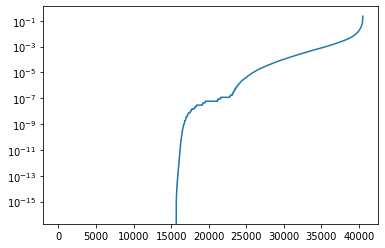

In [27]:
plt.semilogy(np.sort(np.max(np.absolute(df[['acceptor_delta','donor_delta']]),axis=1)))
plt.show()

In [28]:
#with open('/odinn/tmp/benediktj/Data/SplicePrediction-050422/sqtl_deltas_splice_ai_2.pkl', 'wb') as f:
#    pickle.dump(results, f)

In [29]:
t = 0.1
df[np.any([np.absolute(df['acceptor_delta'])>t,np.absolute(df['acceptor_delta'])>t],axis=0)].shape[0]/df.shape[0]

0.0005428345834978287

In [30]:
df2 = df.merge(lead_sQTL[['splice_event_id','Strand','jct_prevalence','Pos_bin','REF','ALT']],on='splice_event_id')

In [31]:
np.any([df['top_a_creation_delta']>t,df['top_d_creation_delta']>t,df['top_a_disruption_delta']>t,df['top_d_disruption_delta']>t],axis=0).shape[0]

40528

In [32]:
t = 0.1
np.sum(np.any([df['top_a_creation_delta']>t,df['top_d_creation_delta']>t,df['top_a_disruption_delta']>t,df['top_d_disruption_delta']>t],axis=0))/df.shape[0]

0.01798756415317805

In [33]:
results = lead_sQTL.merge(df,on='splice_event_id')

In [34]:
variant_anno = pd.read_csv('/nfs/odinn/users/gislih/RNA/requests/rna_paper/splice_anno/clover_snpindel_filtered_junctions_reannotated.01-12-2021.tsv.gz',sep='\t')

In [35]:
tmp = lead_sQTL.merge(variant_anno[['Name','variant_type']],on='Name')

In [36]:
disrupting_variant = tmp[tmp['variant_type']=='disrupting']['splice_event_id'].values
creating_variant = tmp[tmp['variant_type']=='creating']['splice_event_id'].values

In [37]:
disrupting = df[df.index.isin(disrupting_variant)]
np.sum(np.max(disrupting[['top_a_disruption_delta','top_d_disruption_delta']],axis=1)>=0.1)/disrupting.shape[0]

0.004694835680751174

In [38]:
creating = df[df.index.isin(creating_variant)]
np.sum(np.max(creating[['top_a_creation_delta','top_d_creation_delta']],axis=1)>=0.1)/creating.shape[0]

0.015634771732332707